# Aeolus Level 2A product
## Aeolus aerosol/cloud optical product

> Abstract: Access to level 2A product and its visualization

## Load packages, modules and extensions

In [1]:
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest
import numpy as np
from netCDF4 import num2date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from ipywidgets import interact
import ipywidgets as widgets
import xarray as xr
import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

## Product information

The Level 2A aerosol/cloud optical product of the Aeolus mission includes:

- Geo-located consolidated backscatter and extinction profiles
- Backscatter-to-extinction ratio
- LIDAR ratio
- Scene classification
- Heterogeneity index
- Attenuated backscatter signals

Resolution:

- Horizontal resolution of L2A optical properties at observation scale (\~87 km)
- Exceptions are group properties (horizontal accumulation of measurements from \~3 km to \~87 km) and attenuated backscatters (\~3 km)

Note: the resolution of "groups" in the L2A can only go down to 5 measurements at the moment, i.e. \~15 km horizontal resolution.

Documentation:
- https://earth.esa.int/eogateway/catalog/aeolus-l2a-aerosol-cloud-optical-product


### L2A algorithms
Several algorithms were tested and implemented for the Aeolus aerosol product. Not all of them were updated and revised after the launch of the satellite with the availability of real atmospheric measurement data.


#### Different products based on different processing algorithms
- **SCA: Standard Correct Algorithm**  
  Algorithm which makes use of the High Spectral Resolution (HSRL) capabilities of Aeolus to indepdently retrieve backscatter and extinction coefficient profiles by using both Rayleigh and Mie channel.
- **SCA middle bin**  
  SCA algorithm which contains an additional vertical scale to compensate for an oscillating error propagation in the extinction coefficient retrieval at the expense of a reduced vertical resolution. Parameters are averaged over two bins and are assigned to the middle of two consecutive range bins.
- **MCA: Mie channel algorithm**  
  Algorithm based on the Mie channel only which uses a Klett-Fernald-like retrieval with an a-priori assumption of the lidar ratio. This lidar ratio is based on climatological data but is set to \~14 for all geolocations so far.
- **ICA: Iterative correct algorithm**  
  A deprecated algorithm which was developed to detect bins partially filled with particles in order to increase the resolution. Since the algorithm did not provide reliable results in real-world scenes with noisy signals, the further development was stopped.
- **Group product**   
  An algorithm which uses a feature finder to determine groups in which signals are then accumulated and processed with the SCA.


<div class="alert alert-block alert-info">
    <b>&#9757; Recommendation on the use of the products:</b><br>
Apart from the fact that more L2A products are currently under development, the best maintained product to date is the SCA and SCA-mid-bin product.
The product is provided on the Rayleigh altitude scale (SCA) or on an intermediate scale (SCA-mid-bin).
Especially for the extinction coefficient profiles, the SCA-mid-bin is the better choice to avoid the oscillating errors between consecutive range bins. In the case of backscatter coefficient profiles, also the SCA product can be used and provides a better resolution. Keep in mind that the SCA product consists of 24 vertical range bins whereas the SCA mid-bin product consists of only 23 range bins.
</div>
  
  
#### Available SCA and SCA-mid-bin parameters in VirES
Many of the parameters of the L2A product can be obtained via the viresclient. A list of selected parameters can be found in the following table. For a complete list, please refer to the web client which lists the available parameters under the "Data" tab. For an explanation of the parameters, please refer to the VirES web client or the documentation (link above).
A description of the parameters in the table is shown as tooltip when hovering the parameter name.

| Parameter | SCA | SCA mid-bin | Unit |
|:----------|:---:|:-----------:|:----:|
|<code style="background:black;color:white">Observation fields</code>|
|[L1B_start_time_obs](## "Start date and time of Observation (UTC)")  | x | x |   |
|[L1B_centroid_time_obs](## "Centroid date and time of Observation (UTC)")  | x | x |   |
|[longitude_of_DEM_intersection_obs](## "Parameter derived from Longitude of DEM intersection meas. - one value for each observation")  | x | x | DegE |
|[latitude_of_DEM_intersection_obs](## "Parameter derived from Latitude of DEM intersection meas. - one value for each observation")  | x | x | DegN |
|[altitude_of_DEM_intersection_obs](## "Parameter derived from Altitude of DEM intersection meas. - one value for each observation")  | x | x | m |
|[mie_altitude_obs](## "Parameter derived from Mie altitude meas. - one altitude profile for each observation")  | x |   | m |
|[rayleigh_altitude_obs](## "Parameter derived from Rayleigh altitude meas. - one altitude profile for each observation. Rayleigh altitude is the basis for the SCA product.")  | x |   | m |
|[geoid_separation_obs](## "Height of geoid above WGS84 ellipsoid")  | x | x | m |
|[L1B_num_of_meas_per_obs](## "Effective number of measurement in the BRC (Obs.)")  | x | x |   |
|[albedo_off_nadir](## "Albedo off-nadir value")  | x | x |   |
|[sca_mask](## "SCA_applied flag: 1 if the SCA is applied at BRC level; 0 else.")  | x | x |   |
|<code style="background:black;color:white">SCA fields</code>|
|[SCA_time_obs](## "Start date and time of the SCA profile covered by the present DSR (UTC)")  | x | x |   |
|[SCA_middle_bin_altitude_obs](## "Bottom altitude of the middle bin")  |   | x | m |
|[SCA_QC_flag](## "SCA QC flag about processed data: 1 if the first matching bin is clear; 0 else")  | x |   |   |
|[SCA_processing_qc_flag](## "QC information about processing - Bit packed quality field")  | x |   |   |
|[SCA_middle_bin_processing_qc_flag](## "QC information about processing - Bit packed quality field")  |   | x |   |
|[SCA_extinction](## "Particle extinction of the height bin")  | x |   | 10<sup>-6</sup>m<sup>-1</sup>  |
|[SCA_extinction_variance](## "Variance of the extinction coefficient retrieved by the SCA in this bin")  | x |   | m<sup>-2</sup>  |
|[SCA_backscatter](## "Particle extinction of the height bin")  | x |   | 10<sup>-6</sup>m<sup>-1</sup>sr<sup>-1</sup>  |
|[SCA_backscatter_variance](## "Variance of the backscatter coefficient retrieved by the SCA in this bin")  | x |   | m<sup>-2</sup>sr<sup>-2</sup>  |
|[SCA_LOD](## "Particle LOD of the height bin")  | x |   |   |
|[SCA_LOD_variance](## "Variance of the LOD retrieved by the SCA in this bin")  | x |   |   |
|[SCA_middle_bin_extinction](## "Particle extinction of the height bin")  |   | x | 10<sup>-6</sup>m<sup>-1</sup>  |
|[SCA_middle_bin_extinction_variance](## "Variance of the extinction coefficient retrieved by the SCA in this bin")  |   | x | m<sup>-2</sup>  |
|[SCA_middle_bin_backscatter](## "Particle extinction of the height bin")  |   | x | 10<sup>-6</sup>m<sup>-1</sup>sr<sup>-1</sup>  |
|[SCA_middle_bin_backscatter_variance](## "Variance of the backscatter coefficient retrieved by the SCA in this bin")  |   | x | m<sup>-2</sup>sr<sup>-2</sup>  |
|[SCA_middle_bin_LOD](## "Particle LOD of the height bin")  |   | x |   |
|[SCA_middle_bin_LOD_variance](## "Variance of the LOD retrieved by the SCA in this bin")  |   | x |   |
|[SCA_middle_bin_BER](## "Backscatter-to-extinction ratio of the middle bin")  |   | x | sr<sup>-1</sup>  |
|[SCA_middle_bin_BER_variance](## "Variance of the backscatter-to-extinction ratio")  |   | x | sr<sup>-2</sup>  |
|[SCA_SR](## "Scattering ratio of the height bin")  | x |   |   |

  
#### SCA_applied flag (parameter "sca_mask")
The SCA product cannot be applied everywhere. Typically, a few profiles for every orbit file are not processed. This is reported in the sca_applied flag.
On the other hand, all geolocations from the L1B are reported. The sca_applied flag must be used to sort which observations are actually present in the L2A products. 
This must be done for, e.g., the "rayleigh_altitude_obs" and geolocation parameters which are needed for the SCA product. Geolocations or altitudes for the mid-bin product, however, are provided in the SCA-fields.

  
#### QC-flags for SCA (parameter "SCA_processing_qc_flag")
The QC-flags are provided as a bit packed quality field with following flags:  

| Bit no. | Description | Value |
|:--------|:------------|:------|
| 1 | **Extinction:** Rayleigh_SNR==1 AND Extinction_error_bar==1 | valid=1, otherwise=0 |
| 2 | **Backscatter:** Rayleigh_SNR==1 AND Backscatter_error_bar==1 | valid=1, otherwise=0 |
| 3 | **Mie SNR:** Mie_SNR>40 | valid=1, otherwise=0 |
| 4 | **Rayleigh SNR:** Rayleigh_SNR>90 |  valid=1, otherwise=0  |
| 5 | **Extinction error bar:** extinction_estimated_error<1e<sup>-3</sup>m<sup>-1</sup> |  valid=1, otherwise=0 |
| 6 | **Backscatter error bar:** backscatter_estimated_error<1e<sup>-4</sup>m<sup>-1</sup>srm<sup>-1</sup> |  valid=1, otherwise=0 |
| 7 | **cumulative LOD:** accumulated_optical_depth<4 |  valid=1, otherwise=0 |
| 8 | Spare | - |

&#9757; **Note:** The SNRs can be used as the main proxies for quality.

#### QC-flags for SCA-mid-bin (parameter "SCA_middle_bin_processing_qc_flag")
The QC-flags are provided as a bit packed quality field with following flags:  

| Bit no. | Description | Value |
|:--------|:------------|:------|
| 1 | **Extinction:** Rayleigh_SNR==1 AND Extinction_error_bar==1 | valid=1, otherwise=0 |
| 2 | **Backscatter:** Rayleigh_SNR==1 AND Backscatter_error_bar==1 | valid=1, otherwise=0 |
| 3 | **BER**: 0.01<BER<0.1 | valid=1, otherwise=0
| 4 | **Mie SNR:** Mie_SNR>40 | valid=1, otherwise=0 |
| 5 | **Rayleigh SNR:** Rayleigh_SNR>90 |  valid=1, otherwise=0  |
| 6 | **Extinction error bar:** extinction_estimated_error<1e<sup>-3</sup>m<sup>-1</sup> |  valid=1, otherwise=0 |
| 7 | **Backscatter error bar:** backscatter_estimated_error<1e<sup>-4</sup>m<sup>-1</sup>srm<sup>-1</sup> |  valid=1, otherwise=0 |
| 8 | **cumulative LOD:** accumulated_optical_depth<4 |  valid=1, otherwise=0 |

&#9757; **Note:** The SNRs can be used as the main proxies for quality.


#### Further possible QC-criteria

**Proxies for error estimates (based on SNR and lidar signal intensities):**

- SCA_extinction_variance, SCA_middle_bin_extinction_variance
- SCA_backscatter_variance, SCA_middle_bin_backscatter_variance

**Other criteria:**

- SCA_BER_variance, SCA_middle_bin_BER_variance (&#9889; not yet available in VirES)
- SCA_LOD_variance, SCA_middle_bin_LOD_variance
- Heterogeneity index (&#9889; not yet available in VirES)
- SCA_QC_flag: 1==first matching bin is clear; 0==otherwise


<div class="alert alert-block alert-danger">
    <b>&#9889; Please note:</b><br>
Extinction is thresholded to 0 if computation yields a negative result. This practice in the L2A processor might bias statistical studies. This strategy was chosen years ago, because the extinction is too sensitive to small errors  that  propagate  from  one  bin  to  the  next.  Settings  negative  extinction  to  0  provides  more  realistic results.
</div>


## Defining product, parameters and time for the data request
Keep in mind that the time for **one full orbit** is around **90 minutes**.
The **repeat cycle** of the orbits is **7 days**.

In [3]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_2A"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = "2021-08-27T19:30:00Z"
measurement_stop = "2021-08-27T19:44:00Z"

### Define L2A parameters
Observation fields

In [4]:
parameter_observation = [
    "L1B_start_time_obs",
    "L1B_centroid_time_obs",
    "longitude_of_DEM_intersection_obs",
    "latitude_of_DEM_intersection_obs",
    "altitude_of_DEM_intersection_obs",
    "rayleigh_altitude_obs",
    "sca_mask",
]

SCA fields

In [5]:
parameter_sca = [
    "SCA_time_obs",
    "SCA_middle_bin_altitude_obs",
    "SCA_QC_flag",
    "SCA_processing_qc_flag",
    "SCA_middle_bin_processing_qc_flag",
    "SCA_extinction",
    "SCA_extinction_variance",
    "SCA_backscatter",
    "SCA_backscatter_variance",
    "SCA_LOD",
    "SCA_LOD_variance",
    "SCA_middle_bin_extinction",
    "SCA_middle_bin_extinction_variance",
    "SCA_middle_bin_backscatter",
    "SCA_middle_bin_backscatter_variance",
    "SCA_middle_bin_LOD",
    "SCA_middle_bin_LOD_variance",
    "SCA_middle_bin_BER",
    "SCA_middle_bin_BER_variance",
    "SCA_SR",
]

## Retrieve data from VRE server

In [6]:
# Data request for SCA aerosol product
request = AeolusRequest()

request.set_collection(DATA_PRODUCT)

# set observation fields
request.set_fields(
    observation_fields=parameter_observation,
)

# set SCA fields
request.set_fields(
    sca_fields=parameter_sca,
)

# set start and end time and request data
data_sca = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)

# Save data as xarray data set
ds_sca_preliminary = data_sca.as_xarray()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.428MB)

## Retrieve additional SNR data from L1B-product from VRE server
SNR data is not stored in the L2A-product but is used for the L2A-QC-flag and can thus not be used for manual thresholding.
As a solution, the L1B SNR data is loaded as additional data.

In [7]:
# Data request for SCA aerosol product
request = AeolusRequest()

request.set_collection("ALD_U_N_1B")

# set observation fields
request.set_fields(
    observation_fields=["rayleigh_SNR", "mie_SNR", "rayleigh_altitude", "mie_altitude", "time"],
)

# set start and end time and request data
data_L1B = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)

# Save data as xarray data set
ds_L1B = data_L1B.as_xarray()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.1MB)

## Remove duplicate profiles in L2A product
Especially at the border of two L2A raw data files, duplicates can be present. These must be removed by using the time parameters.
It can happen that they are also present in data which is retrieved from the VirES server.

In [8]:
# Create mask of unique profiles
_, unique_mask = np.unique(ds_sca_preliminary["SCA_time_obs"], return_index=True)

# Create new dataset and fill in L2A dataset variables with applied unique_mask
ds_sca = xr.Dataset()
for param in ds_sca_preliminary.keys():
    ds_sca[param] = (ds_sca_preliminary[param].dims, ds_sca_preliminary[param].data[unique_mask], ds_sca_preliminary[param].attrs)
del ds_sca_preliminary

## Plot overview map

Text(0.5, 1.0, 'Aeolus orbit \n from 2021-08-27T19:30:00Z to 2021-08-27T19:44:00Z')

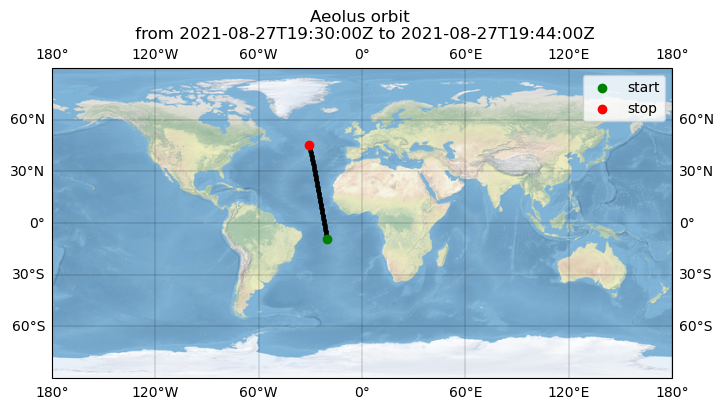

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
ax.scatter(
    ds_sca["longitude_of_DEM_intersection_obs"],
    ds_sca["latitude_of_DEM_intersection_obs"],
    marker="o",
    c="k",
    s=5,
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_sca["longitude_of_DEM_intersection_obs"][0],
    ds_sca["latitude_of_DEM_intersection_obs"][0],
    marker="o",
    c="g",
    edgecolor="g",
    label="start",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_sca["longitude_of_DEM_intersection_obs"][-1],
    ds_sca["latitude_of_DEM_intersection_obs"][-1],
    marker="o",
    c="r",
    edgecolor="r",
    label="stop",
    transform=ccrs.Geodetic(),
)
ax.legend()
ax.set_title("Aeolus orbit \n from {} to {}".format(measurement_start, measurement_stop))

## Add datetime variable to the data sets

In [10]:
ds_sca["SCA_time_obs_datetime"] = (
    ("sca_dim"),
    num2date(ds_sca["SCA_time_obs"], units="s since 2000-01-01", only_use_cftime_datetimes=False),
)

ds_sca["L1B_start_time_obs_datetime"] = (
    ("observation"),
    num2date(
        ds_sca["L1B_start_time_obs"], units="s since 2000-01-01", only_use_cftime_datetimes=False
    ),
)

ds_sca["L1B_centroid_time_obs_datetime"] = (
    ("observation"),
    num2date(
        ds_sca["L1B_centroid_time_obs"], units="s since 2000-01-01", only_use_cftime_datetimes=False
    ),
)

ds_L1B["datetime"] = (
    ("observation"),
    num2date(ds_L1B["time"], units="s since 2000-01-01", only_use_cftime_datetimes=False),
)

## Extract bits from processing_qc_flag and add them to the data sets for QC (see above for explanation)

In [11]:
ds_sca["SCA_validity_flags"] = (
    ("sca_dim", "array_24", "array_8"),
    np.unpackbits(
        ds_sca["SCA_processing_qc_flag"][:, :].values.view(np.uint8), bitorder="little"
    ).reshape([-1, 24, 8]),
)
ds_sca["SCA_middle_bin_validity_flags"] = (
    ("sca_dim", "array_23", "array_8"),
    np.unpackbits(
        ds_sca["SCA_middle_bin_processing_qc_flag"][:, :].values.view(np.uint8), bitorder="little"
    ).reshape([-1, 23, 8]),
)

## Add SCA/SCA-mid-bin geolocation and SCA altitude 
See explanation above for SCA_applied flag.
Geolocation and altitude parameters are defined on the basis of "observation_fields" which are filtered by "sca_mask" (sca_applied flag).

In [12]:
# SCA altitude
ds_sca["SCA_bin_altitude_obs"] = (
    ("sca_dim", "array_25"),
    ds_sca["rayleigh_altitude_obs"][ds_sca["sca_mask"].astype(bool)].data,
)
# SCA and SCA-mid-bin longitude
ds_sca["SCA_longitude"] = (
    ("sca_dim"),
    ds_sca["longitude_of_DEM_intersection_obs"][ds_sca["sca_mask"].astype(bool)].data,
)
# SCA and SCA-mid-bin latitude
ds_sca["SCA_latitude"] = (
    ("sca_dim"),
    ds_sca["latitude_of_DEM_intersection_obs"][ds_sca["sca_mask"].astype(bool)].data,
)

## Add SCA/SCA-mid-bin altitude for CoG
Altitude are given for the range bin boundaries but center altitude are needed for profile plots.

In [13]:
# SCA altitude for range bin center
ds_sca["SCA_bin_altitude_center_obs"] = (
    ("sca_dim", "array_24"),
    ds_sca["SCA_bin_altitude_obs"][:, 1:].data
    - ds_sca["SCA_bin_altitude_obs"].diff(dim="array_25").data / 2.0,
)

# SCA mid-bin altitude for range bin center
ds_sca["SCA_middle_bin_altitude_center_obs"] = (
    ("sca_dim", "array_23"),
    ds_sca["SCA_middle_bin_altitude_obs"][:, 1:].data
    - ds_sca["SCA_middle_bin_altitude_obs"].diff(dim="array_24").data / 2.0,
)

## Add lidar ratio
Lidar ratio is just the inverse of the backscatter to extinction ratio (BER)

In [14]:
ds_sca["SCA_middle_bin_lidar_ratio"] = (
    ("sca_dim", "array_23"),
    1.0 / ds_sca["SCA_middle_bin_BER"].data,
)

## Add L1B_SNR to SCA dataset
L1B SNR can be used as the main proxy for QC-filtering.

In [15]:
# SNR for SCA
rayleigh_SNR = ds_L1B["rayleigh_SNR"][:, :-1][ds_sca["sca_mask"].astype(bool)].data
ds_sca["SCA_rayleigh_SNR"] = (
    ("sca_dim", "array_24"),
    rayleigh_SNR,
)
mie_SNR = ds_L1B["mie_SNR"][:, :-1][ds_sca["sca_mask"].astype(bool)].data
ds_sca["SCA_mie_SNR"] = (
    ("sca_dim", "array_24"),
    mie_SNR,
)

# SNR for SCA_middle_bin
rayleigh_SNR_mid_bin = (rayleigh_SNR[:, :-1] + rayleigh_SNR[:, 1:]) / 2.0
ds_sca["SCA_middle_bin_rayleigh_SNR"] = (
    ("sca_dim", "array_23"),
    rayleigh_SNR_mid_bin,
)
mie_SNR_mid_bin = (mie_SNR[:, :-1] + mie_SNR[:, 1:]) / 2.0
ds_sca["SCA_middle_bin_mie_SNR"] = (
    ("sca_dim", "array_23"),
    mie_SNR_mid_bin,
)

## Scale backscatter and extinction with 1e-6
Backscatter and extinction values in the L2A product are scaled with 1e-6.

In [16]:
for parameter in [
    "SCA_extinction",
    "SCA_backscatter",
    "SCA_middle_bin_extinction",
    "SCA_middle_bin_backscatter",
]:
    ds_sca[parameter] *= 1e-6

## Plot parameter
A class for filtering and interactive plotting of L2A data.

In [17]:
class PlotData:
    """
    Class for plotting L2A data

    Parameters
    ----------
    L2A_algorithm : string
        L2A algorithm to plot. Can be only 'SCA' at the moment. 
        Will be extended by further algorithms, e.g. 'MCA'.
    """

    def __init__(self, L2A_algorithm):
        self.L2A_algorithm = L2A_algorithm
        self.ds = self.select_dataset()

    def select_dataset(self):
        """Selects the dataset dependent on the L2A algorithm"""
        dataset_dict = {"SCA": ds_sca}
        return dataset_dict[self.L2A_algorithm]

    def select_parameter(self, parameter):
        """Selects the parameter data for plotting and sets the product
        variable depending on the parameter."""
        self.parameter = parameter
        self.parameter_data = np.copy(self.ds[parameter].data)
        if hasattr(self.ds[parameter], 'units'):
            self.parameter_unit = self.ds[parameter].units
        else:
            self.parameter_unit = 'a.u.'
        # distinguish between SCA and SCA_middle_bin
        if "SCA_middle_bin" in parameter:
            self.product = "SCA_middle_bin"
        else:
            self.product = parameter.split("_")[0]

    def select_validity_flag(self):
        """Select the corresponding validity flag for the product"""
        if self.product == "SCA_middle_bin":
            validity_flag = self.ds["SCA_middle_bin_validity_flags"]
        elif self.product == "SCA":
            validity_flag = self.ds["SCA_validity_flags"]
        return validity_flag.data

    def select_SNR_parameter(self):
        """Select the corresponding SNR parameter for the product"""
        if self.product == "SCA_middle_bin":
            rayleigh_SNR = self.ds["SCA_middle_bin_rayleigh_SNR"]
            mie_SNR = self.ds["SCA_middle_bin_mie_SNR"]
        elif self.product == "SCA":
            rayleigh_SNR = self.ds["SCA_rayleigh_SNR"]
            mie_SNR = self.ds["SCA_mie_SNR"]
        return rayleigh_SNR.data, mie_SNR.data

    def apply_QC_filter(self):
        """Applies the QC filter depending on validity flag and QC_flag for
        first matching bin"""
        validity_flag = self.select_validity_flag()
        # filter extinction and LOD for extinction flag
        if any(i in self.parameter for i in ["extinction", "LOD"]):
            self.parameter_data[validity_flag[:, :, 0] == 0] = np.nan
        # filter backscatter and SR for backscatter flag
        elif any(i in self.parameter for i in ["backscatter", "SR"]):
            self.parameter_data[validity_flag[:, :, 1] == 0] = np.nan
        # filter BER and lidar ratio for backscatter and extinction flag
        elif any(i in self.parameter for i in ["BER", "lidar_ratio"]):
            self.parameter_data[np.any(validity_flag[:, :, 0:2] == 0, axis=2)] = np.nan

        # filter for first matching bin is clear or not
        self.parameter_data[self.ds["SCA_QC_flag"] == 0] = np.nan

    def apply_SNR_filter(self, rayleigh_SNR_threshold, mie_SNR_threshold):
        """Applies a filter depending on SNR values"""
        rayleigh_SNR, mie_SNR = self.select_SNR_parameter()
        # Create mask based on both the Rayleigh and Mie SNR
        # Could also be separated
        SNR_mask = (rayleigh_SNR < rayleigh_SNR_threshold) | (mie_SNR < mie_SNR_threshold)
        self.parameter_data[SNR_mask] = np.nan

    def determine_vmin_vmax(self, z, vmin=None, vmax=None, percentile=99):
        """
        Determines limit values for plots

        """
        if vmin is None:
            vmin = 0
        if vmax is None:
            vmax = np.nanpercentile(z, percentile)
        return vmin, vmax

    def determine_xyz(self, start_bin, end_bin):
        """
        Determines time parameter (x), altitude parameter (y) and parameter of
        interest (z) for the pcolormesh plot.
        The parameters are sliced according to start_bin and end_bin.
        Altitude parameter is scaled to km instead of m.
        """
        x = self.ds["SCA_time_obs_datetime"][start_bin:end_bin]
        if self.product == "SCA_middle_bin":
            y = self.ds["SCA_middle_bin_altitude_obs"][start_bin:end_bin] / 1000.0
            y_profile = self.ds["SCA_middle_bin_altitude_center_obs"][start_bin:end_bin] / 1000.0
        elif self.product == "SCA":
            y = self.ds["SCA_bin_altitude_obs"][start_bin:end_bin] / 1000.0
            y_profile = self.ds["SCA_bin_altitude_center_obs"][start_bin:end_bin] / 1000.0
        z = self.parameter_data[start_bin:end_bin]
        return x, y, z, y_profile

    def determine_xy(self, profile_time, no_profiles_avg):
        """
        Determines closest profile to the profile time of interest.
        Selects the corresponding altitude (x) and profile of parameter of
        interest (y) with optional averaging (no_profiles_avg).
        """
        time_data = self.ds["SCA_time_obs_datetime"]
        profile_id = np.argmin(np.abs(time_data.data - np.datetime64(profile_time)))

        if self.product == "SCA_middle_bin":
            x = self.ds["SCA_middle_bin_altitude_center_obs"][profile_id][:] / 1000.0
        elif self.product == "SCA":
            x = self.ds["SCA_bin_altitude_center_obs"][profile_id][:] / 1000.0
        y = np.mean(
            self.parameter_data[
                profile_id - int(no_profiles_avg / 2) : profile_id + int(no_profiles_avg / 2) + 1, :
            ],
            axis=0,
        )
        return x, y

    def get_DEM_altitude_data(self, start_bin, end_bin):
        """
        Selects the DEM altitude which is part of the observation_level
        parameters and thus has to be filtered with the sca_mask.
        """
        DEM_altitude = (
            self.ds["altitude_of_DEM_intersection_obs"][self.ds["sca_mask"].astype(bool)] / 1000.0
        )
        return DEM_altitude[start_bin:end_bin]

    def get_geolocation_data(self, start_bin, end_bin):
        """Selects latitude and longitude parameters which are part of the
        observation_level parameters and thus have to be filtered with the sca_mask"""
        latitude = self.ds["latitude_of_DEM_intersection_obs"][self.ds["sca_mask"].astype(bool)]
        longitude = self.ds["longitude_of_DEM_intersection_obs"][self.ds["sca_mask"].astype(bool)]
        return latitude[start_bin:end_bin], longitude[start_bin:end_bin]

    def draw_2D(self, fig, ax, x, y, z, vmin, vmax, DEM_altitude_data):
        """Draws a 2D curtain plot with the pcolormesh routine"""
        im = ax.pcolormesh(x, y.T, z[:-1, :].T, vmin=vmin, vmax=vmax, cmap="viridis")
        if DEM_altitude_data is not None:
            ax.plot(x, DEM_altitude_data, "r-", label="DEM altitude")
        ax.set_ylim(-1, 25)
        ax.set_xlabel("Date [UTC]")
        ax.set_ylabel("Altitude [km]")
        ax.set_title("{} - {}".format(self.product, self.parameter))
        ax.grid()
        ax.legend()
        locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        fig.colorbar(im, ax=ax, aspect=50, pad=0.001, label=self.parameter_unit)

    def draw_profile(self, ax, x, y, vmin, vmax, ymin, ymax, profile_time):
        """Draws a profile plot"""
        ax.plot(y, x, "ro-")
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(ymin, ymax)
        ax.grid()
        ax.set_ylabel("Altitude [km]")
        ax.set_xlabel(f"{self.parameter} [{self.parameter_unit}]")
        ax.set_title("{} - {} \n at {}".format(self.product, self.parameter, profile_time))

    def draw_map(self, ax, lat, lon):
        """Draws a map with cartopy"""
        ax.stock_img()
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
        ax.scatter(
            lon,
            lat,
            marker="o",
            c="k",
            s=5,
            transform=ccrs.Geodetic(),
        )

    def plot_2D(self, vmin=None, vmax=None, start_bin=0, end_bin=-1, DEM_altitude=True):
        """
        Create 2D curtain plot
        """
        x, y, z, y_profile = self.determine_xyz(start_bin, end_bin)
        vmin, vmax = self.determine_vmin_vmax(z, vmin, vmax, 90)
        if DEM_altitude:
            DEM_altitude_data = self.get_DEM_altitude_data(start_bin, end_bin)
        else:
            DEM_altitude = None
        fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
        self.draw_2D(fig, ax, x, y, z, vmin, vmax, DEM_altitude_data)

    def plot_profile(self, profile_time, no_profiles_avg, vmin=None, vmax=None, ymin=-1, ymax=25):
        """
        Create profile plot
        """
        x, y = self.determine_xy(profile_time, no_profiles_avg)
        vmin, vmax = self.determine_vmin_vmax(y, vmin, vmax, 100)
        vmin = -vmax / 10.0
        fig, ax = plt.subplots(1, 1, figsize=(6, 10), constrained_layout=True)
        self.draw_profile(ax, x, y, vmin, vmax, ymin, ymax, profile_time)

    def plot_interactive(self, vmin=None, vmax=None, start_bin=0, end_bin=-1, DEM_altitude=True):
        """
        Create interactive plot with 2D curtain plot, profile plot and map plot by using ipywidgets
        """
        self.fig = plt.figure(figsize=(10, 10))  # , constrained_layout=True)
        gs = self.fig.add_gridspec(2, 4)
        self.ax_2D = self.fig.add_subplot(gs[0:1, :-1])
        self.ax_map = self.fig.add_subplot(gs[1:, 0:], projection=ccrs.PlateCarree())
        self.ax_profile = self.fig.add_subplot(gs[0:1, -1], sharey=self.ax_2D)

        self.x, self.y, self.z, self.y_profile = self.determine_xyz(start_bin, end_bin)
        vmin, vmax = self.determine_vmin_vmax(self.z, vmin, vmax, 90)
        if DEM_altitude:
            DEM_altitude_data = self.get_DEM_altitude_data(start_bin, end_bin)
        else:
            DEM_altitude = None
        self.latitude, self.longitude = self.get_geolocation_data(start_bin, end_bin)
        self.draw_2D(self.fig, self.ax_2D, self.x, self.y, self.z, vmin, vmax, DEM_altitude_data)
        self.draw_map(self.ax_map, self.latitude, self.longitude)
        profile_id = [(str(i), j) for j, i in enumerate(self.x.data)]
        self.vline = None
        self.profile_geolocation = None
        self.draw_interactive(10, 1)
        self.ax_map.legend()
        self.ax_2D.legend()
        self.fig.tight_layout()

        interact(
            self.draw_interactive,
            no_profiles_avg=widgets.IntSlider(
                value=1,
                min=1,
                max=10,
                step=2,
                continuous_update=False,
                layout={"width": "500px"},
                description="Profiles to average",
                style={"description_width": "initial"},
            ),
            profile_id=widgets.SelectionSlider(
                options=profile_id[0:-1],
                value=profile_id[0][1],
                continuous_update=False,
                layout={"width": "500px"},
                description="Profile time",
                style={"description_width": "initial"},
            ),
        )

    def draw_interactive(self, profile_id, no_profiles_avg):
        """
        Function which can be called interactively to draw 2D plot,
        profile plot and map plot.
        It updates the selected profile marker in the 2D- and map plot and
        calculates the mean profile to create the profile plot.
        """
        x = self.y_profile[profile_id][:]
        y = np.nanmean(
            self.z[
                profile_id - int(no_profiles_avg / 2) : profile_id + int(no_profiles_avg / 2) + 1, :
            ],
            axis=0,
        )
        vmin, vmax = self.determine_vmin_vmax(y, vmin=None, vmax=None, percentile=100)
        profile_time = str(self.x[profile_id].data)
        self.ax_profile.clear()
        self.draw_profile(
            self.ax_profile,
            x,
            y,
            vmin=-vmax / 10.0,
            vmax=vmax,
            ymin=-1,
            ymax=25,
            profile_time=profile_time,
        )
        # self.ax_profile.set_ylabel(" ")
        self.ax_profile.set_title(profile_time[:22])
        self.ax_profile.set_xlabel(f"{self.parameter} \n [{self.parameter_unit}]")
        if self.vline is not None:
            self.vline.set_xdata(
                self.x[profile_id].data
                + (self.x[profile_id + 1].data - self.x[profile_id].data) / 2.0
            )
        else:
            self.vline = self.ax_2D.axvline(
                self.x[profile_id].data
                + (self.x[profile_id + 1].data - self.x[profile_id].data) / 2.0,
                c="r",
                ls="--",
                label="selected profile",
            )
        if self.profile_geolocation is not None:
            self.profile_geolocation.remove()
        self.profile_geolocation = self.ax_map.scatter(
            self.longitude[profile_id],
            self.latitude[profile_id],
            marker="o",
            c="r",
            s=10,
            transform=ccrs.Geodetic(),
            label="selected profile",
        )

Create a new instance of the Plot Class with the L2A algorithm as parameter.

In [18]:
L2A_plot = PlotData(L2A_algorithm="SCA")

Select a parameter from the L1B product and apply QC or SNR filter.  
Create a 2D-plot, a profile plot or an interactive plot with both of them.
Just (un)comment the necessary methods.
The interactive plot provides option for choosing a profile and an average over neighbouring profiles.
Please note that the possible change of the altitudes between neighbouring profiles and thus range bins is not considered for the averaging.

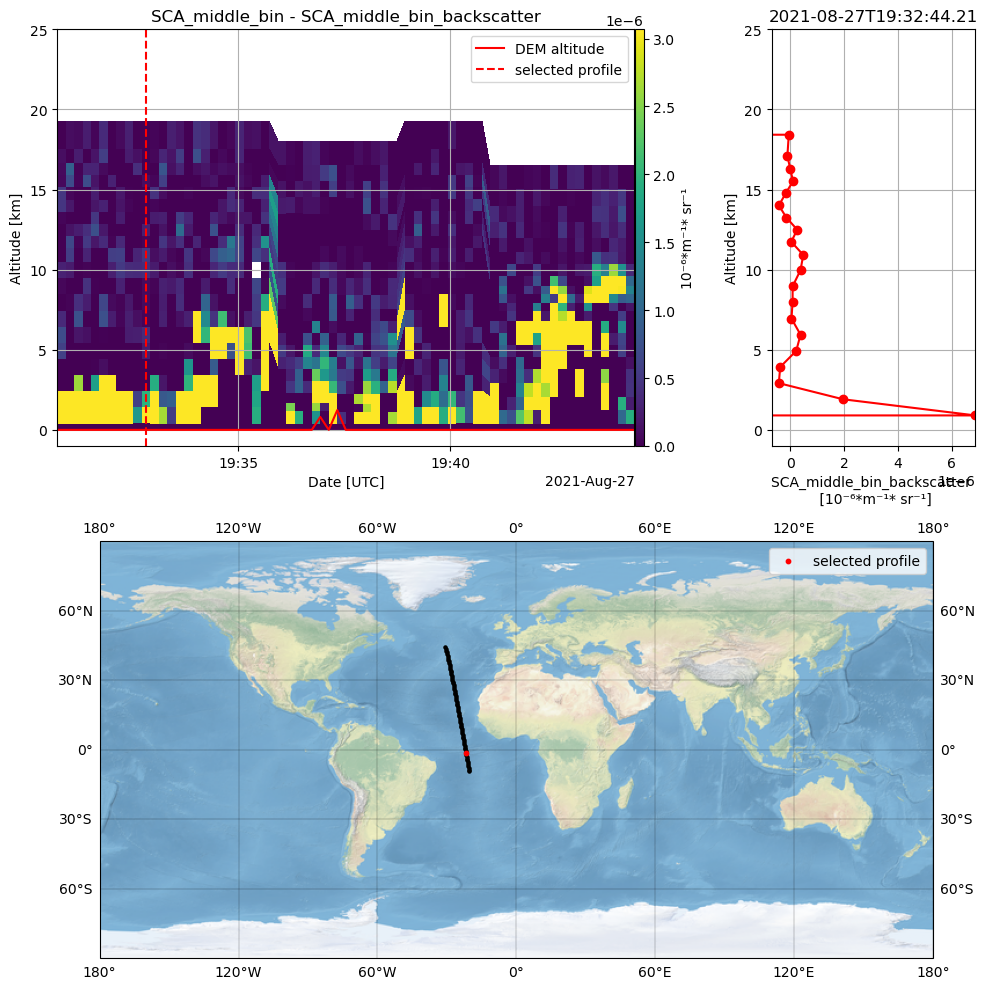

interactive(children=(SelectionSlider(continuous_update=False, description='Profile time', layout=Layout(width…

In [19]:
L2A_plot.select_parameter("SCA_middle_bin_backscatter")

## apply QC filter
# L2A_plot.apply_QC_filter()

## apply filter based on SNR
L2A_plot.apply_SNR_filter(rayleigh_SNR_threshold=15, mie_SNR_threshold=15)

## plot 2D curtain plot
# L2A_plot.plot_2D()

## plot profile plot
# L2A_plot.plot_profile(profile_time='2021-08-27T19:37:08', no_profiles_avg=1)

## plot interactive
L2A_plot.plot_interactive()

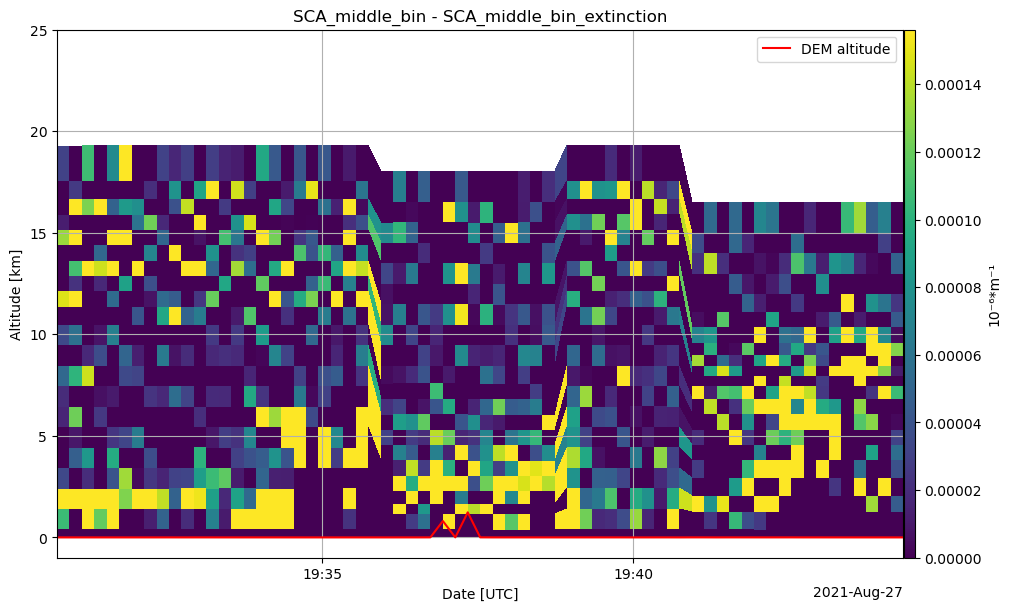

In [20]:
L2A_plot.select_parameter("SCA_middle_bin_extinction")
L2A_plot.apply_SNR_filter(rayleigh_SNR_threshold=10, mie_SNR_threshold=10)
L2A_plot.plot_2D()

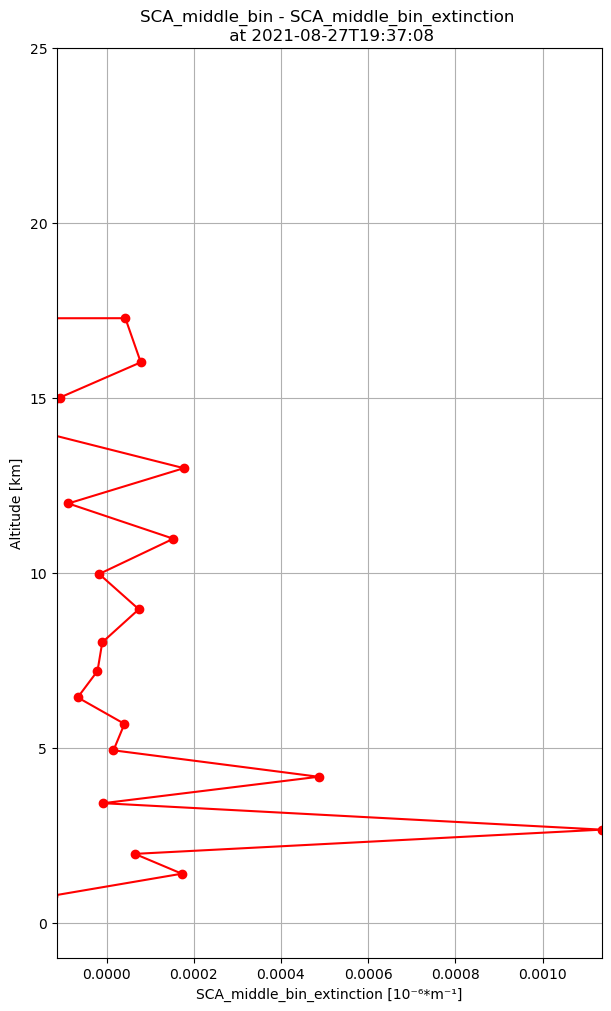

In [21]:
L2A_plot.select_parameter("SCA_middle_bin_extinction")
L2A_plot.apply_SNR_filter(10, 10)
L2A_plot.plot_profile(profile_time='2021-08-27T19:37:08', no_profiles_avg=1)